<a href="https://colab.research.google.com/github/ajit2704/Reinforcement-Learning-on-google-colab/blob/master/CEM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment setup

---



In [0]:
!apt-get install -y python-numpy python-dev cmake zlib1g-dev libjpeg-dev xvfb libav-tools xorg-dev python-opengl libboost-all-dev libsdl2-dev swig

In [0]:
!pip install pyvirtualdisplay
!pip install piglet

In [0]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

In [0]:
!pip install gym

# Crossentropy method

---


This notebook will teach you to solve reinforcement learning problems with crossentropy method. We'll follow-up by scaling everything up and using neural network policy.

In [0]:
import gym
import numpy as np, pandas as pd

env = gym.make("Taxi-v2")
env.reset()
env.render()

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [0]:
n_states = env.observation_space.n
n_actions = env.action_space.n

print("n_states=%i, n_actions=%i"%(n_states, n_actions))

n_states=500, n_actions=6


# Create stochastic policy

---


This time our policy should be a probability distribution.

policy[s,a] = P(take action a | in state s)

Since we still use integer state and action representations, you can use a 2-dimensional array to represent the policy.

Please initialize policy uniformly, that is, probabililities of all actions should be equal

In [0]:
policy = np.ones((n_states, n_actions))/n_actions

In [0]:
def generate_session(policy,t_max=10**4):
    """
    Play game until end or for t_max ticks.
    :param policy: an array of shape [n_states,n_actions] with action probabilities
    :returns: list of states, list of actions and sum of rewards
    """
    states,actions = [],[]
    total_reward = 0.
    
    s = env.reset()
    
    for t in range(t_max):
        
        a = np.random.choice(n_actions, 1, p=policy[s])[0]
        
        new_s, r, done, info = env.step(a)
        
        #Record state, action and add up reward to states,actions and total_reward accordingly. 
        states.append(s)
        actions.append(a)
        total_reward += r
        
        s = new_s
        if done:
            break
    return states, actions, total_reward

In [0]:
s,a,r = generate_session(policy)

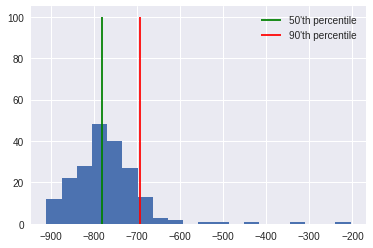

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

sample_rewards = [generate_session(policy,t_max=1000)[-1] for _ in range(200)]

plt.hist(sample_rewards,bins=20);
plt.vlines([np.percentile(sample_rewards, 50)], [0], [100], label="50'th percentile", color='green')
plt.vlines([np.percentile(sample_rewards, 90)], [0], [100], label="90'th percentile", color='red')
plt.legend()

# Play the game

---


Just like before, but we also record all states and actions we took.

In [0]:
def select_elites(states_batch,actions_batch,rewards_batch,percentile=50):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i][t]
    
    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions
    
    Please return elite states and actions in their original order 
    [i.e. sorted by session number and timestep within session]
    
    If you're confused, see examples below. Please don't assume that states are integers (they'll get different later).
    """
    
    reward_threshold = np.percentile(rewards_batch, percentile)
    
    elite_states  = [s for i in range(len(states_batch)) if rewards_batch[i]>=reward_threshold for s in states_batch[i]]
    elite_actions = [a for i in range(len(actions_batch)) if rewards_batch[i]>=reward_threshold for a in actions_batch[i]]
    
    return elite_states,elite_actions

In [0]:
from collections import defaultdict
def update_policy(elite_states,elite_actions):
    """
    Given old policy and a list of elite states/actions from select_elites,
    return new updated policy where each action probability is proportional to
    
    policy[s_i,a_i] ~ #[occurences of si and ai in elite states/actions]
    
    Don't forget to normalize policy to get valid probabilities and handle 0/0 case.
    In case you never visited a state, set probabilities for all actions to 1./n_actions
    
    :param elite_states: 1D list of states from elite sessions
    :param elite_actions: 1D list of actions from elite sessions
    
    """
    
    new_policy = np.zeros([n_states,n_actions])
    
    #Don't forget to set 1/n_actions for all actions in unvisited states.
    state_action_dict = defaultdict(lambda: [0]*n_actions)
    for i in range(len(elite_states)):
        state_action_dict[elite_states[i]][elite_actions[i]]+=1
    for i in range(n_states):
        if i not in state_action_dict:
            new_policy[i] = [1/n_actions]*n_actions
        else:
            new_policy[i] = [p/sum(state_action_dict[i]) for p in state_action_dict[i]]
    
    
    return new_policy

# Training loop

---


Generate sessions, select N best and fit to those.

In [0]:
from IPython.display import clear_output

def show_progress(batch_rewards, log, percentile, reward_range=[-990,+10]):
    """
    A convenience function that displays training progress. 
    No cool math here, just charts.
    """
    
    mean_reward, threshold = np.mean(batch_rewards), np.percentile(batch_rewards, percentile)
    log.append([mean_reward,threshold])

    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f"%(mean_reward, threshold))
    plt.figure(figsize=[8,4])
    plt.subplot(1,2,1)
    plt.plot(list(zip(*log))[0], label='Mean rewards')
    plt.plot(list(zip(*log))[1], label='Reward thresholds')
    plt.legend()
    plt.grid()
    
    plt.subplot(1,2,2)
    plt.hist(batch_rewards,range=reward_range);
    plt.vlines([np.percentile(batch_rewards, percentile)], [0], [100], label="percentile", color='red')
    plt.legend()
    plt.grid()

    plt.show()

In [0]:
policy = np.ones([n_states, n_actions]) / n_actions

mean reward = -80.132, threshold=5.000


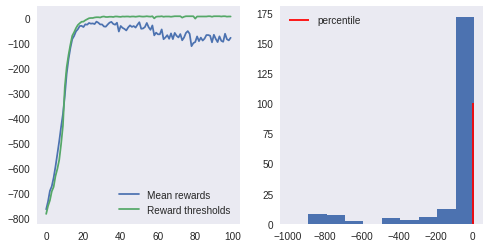

In [0]:
n_sessions = 250  #sample this many sessions
percentile = 50  #take this percent of session with highest rewards
learning_rate = 0.5  #add this thing to all counts for stability

log = []

for i in range(100):
    
    sessions = [generate_session(policy) for _ in range(n_sessions)]
    
    batch_states,batch_actions,batch_rewards = zip(*sessions)

    elite_states, elite_actions = select_elites(batch_states,batch_actions,batch_rewards,percentile)
    
    new_policy = update_policy(elite_states,elite_actions)
    
    policy = learning_rate * new_policy + (1-learning_rate) * policy
    
    #display results on chart
    show_progress(batch_rewards, log, percentile)